/tmp/ipykernel_176665/2871407031.py:4: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


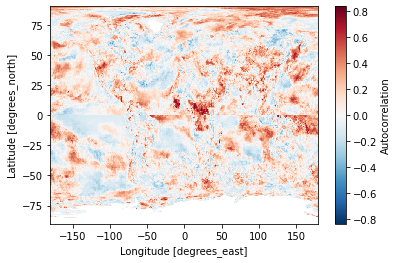

In [1]:
from paths import heat_out_merra2
import numpy as np
import xarray
from scipy.stats.stats import pearsonr

exp_num = "3136"
merra = xarray.open_dataset([path for path in heat_out_merra2() if exp_num in path and "tx" in path][0])["HWF_tx9pct"].dt.days

def autocorrelation(o_data: xarray.DataArray) -> xarray.DataArray:
    """
    Calculates correlation between dataset and itself shifted by one time interval
    o_data -> Data array with dimensions latitude, longitude, and time
    """
    shifted_data = o_data.shift(time=1)

    o_data_vals = np.moveaxis(o_data.values, 0, -1)
    shifted_data_vals = np.moveaxis(shifted_data.values, 0, -1)
    correlation = np.zeros((o_data_vals.shape[0], o_data_vals.shape[1]))

    for i in range(0, o_data_vals.shape[0]):
        for j in range(0, o_data_vals.shape[1]):
            correlation[i][j] = pearsonr(np.nan_to_num(o_data_vals[i][j]), np.nan_to_num(shifted_data_vals[i][j]))[0]
    correlation_data = o_data.mean(dim="time").rename("Autocorrelation")
    correlation_data.values = correlation
    return correlation_data

merra_detrended = detrend(merra)
autocorr = autocorrelation(merra_detrended)

autocorr.plot()

In [37]:
trends = merra.polyfit(dim="time", deg=1)["polyfit_coefficients"]
def sub_trend(point):
    lat = point.points.values.item()[0]
    lon = point.points.values.item()[1]
    time = point.points.values.item()[2]
    value = point.values
    new_value = value - (trends.sel(degree=1).sel(lat=lat).sel(lon=lon)*time + trends.sel(degree=0).sel(lat=lat).sel(lon=lon))
    point.values = new_value
    return point
detrended = merra.stack(points=['lat','lon', 'time']).groupby('points').apply(sub_trend)

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out

KeyboardInterrupt



In [33]:
trends.sel(degree=1)

<xarray.DataArray 'polyfit_coefficients' (lat: 361, lon: 576)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-0.04033613, -0.02773109, -0.02773109, ..., -0.04705882,
        -0.04089636, -0.04033613],
       [-0.04901961, -0.04901961, -0.05406162, ..., -0.04901961,
        -0.04901961, -0.04901961],
       [-0.04313725, -0.04313725, -0.04313725, ..., -0.04313725,
        -0.04313725, -0.04313725]])
Coordinates:
    degree   int64 1
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

In [4]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML
import xarray
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin
import xesmf as xe
import numpy as np

def bilinear_interpolation(data_to_interpolate: xarray.DataArray, data_to_match: xarray.DataArray) -> xarray.DataArray:
    regridder = xe.Regridder(data_to_interpolate, data_to_match, 'bilinear')
    return regridder(data_to_interpolate)

exp_num = "3136"

land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()

all_min, xghg_min, xaer_min = tmin()
all_ds = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"HWF_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).mean(dim="member")
aer_ds = all_ds - xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"HWF_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).mean(dim="member")
pop_ds = xarray.open_dataset("/projects/dgs/persad_research/heat_research/data/population/population_histsoc_30arcmin_annual_1901_2020.nc", decode_times=False)["popc"]

aer_ds = aer_ds.assign_coords(lon=(((aer_ds.lon + 180) % 360) - 180)).sortby('lon')
aer_data = aer_ds.sel(time=slice(aer_ds.time.min(), aer_ds.time.min() + pop_ds.time.max()))
pop_data = bilinear_interpolation(pop_ds, aer_ds.mean(dim="time"))

Overwrite existing file: bilinear_360x720_192x288.nc 
 You can set reuse_weights=True to save computing time.


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/pytho

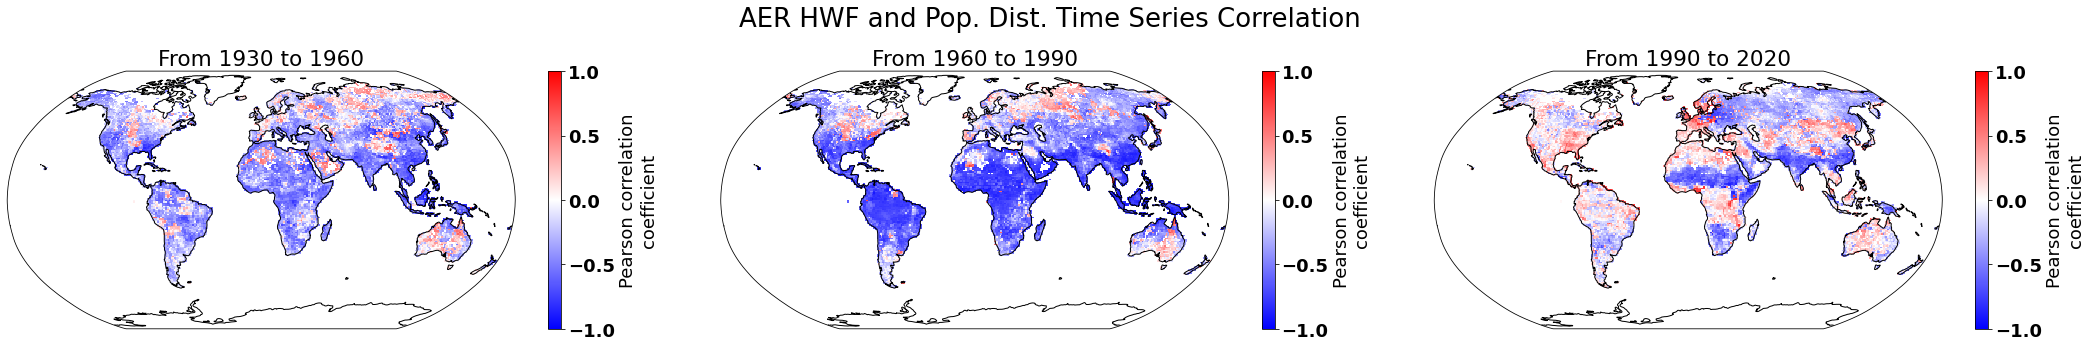

In [15]:
def sig_mask(ds1_ds, ds2_ds):
    ds1_array = ds1_ds.values
    ds2_array = ds2_ds.values
    
    results = []
    
    for lati, lat in enumerate(ds1_ds.lat.values):
        for loni, lon in enumerate(ds1_ds.lon.values):
            ds1_pt = ds1_array[0:ds1_ds["time"].size, lati, loni].flatten()
            ds2_pt = ds2_array[0:ds2_ds["time"].size, lati, loni].flatten()
            results.append((np.corrcoef(ds1_pt, ds2_pt)[0][1], lat, lon))
    
    if len(results) == ds1_ds.lat.size*ds1_ds.lon.size:
        pass
    else:
        raise RuntimeError(f'The mask size does not match the original dataset size: {len(mask)} != {ds1_ds.lat.size*ds1_ds.lon.size}')
    
    # Recycle ALL array
    return_array = (ds1_ds.mean(dim="time").load() * 0).rename("Pearson correlation coefficient")
    for index, (value, lat, lon) in enumerate(results):
        return_array.loc[dict(lat=lat, lon=lon)] = value
    
    return return_array

rc('font', **{'weight': 'bold', 'size': 18})
# (ax4, ax5, ax6) for when future projections are added
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"AER HWF and Pop. Dist. Time Series Correlation", fontsize=26)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

vmax=1
vmin=-1
cmap="bwr"

year_min=1930
year_max=1960
cor_mask = sig_mask(aer_data.sel(time=slice(year_min, year_max)), pop_data.sel(time=slice(year_min-1901, year_max-1901)))
cor_mask.plot(ax=ax1, transform=ccrs.PlateCarree(), cmap=cmap, vmax=vmax, vmin=vmin)
ax1.coastlines()
ax1.set_title(f"From {year_min} to {year_max}")


year_min=1960
year_max=1990
cor_mask = sig_mask(aer_data.sel(time=slice(year_min, year_max)), pop_data.sel(time=slice(year_min-1901, year_max-1901)))
cor_mask.plot(ax=ax2, transform=ccrs.PlateCarree(), cmap=cmap, vmax=vmax, vmin=vmin)
ax2.coastlines()
ax2.set_title(f"From {year_min} to {year_max}")


year_min=1990
year_max=2020
cor_mask = sig_mask(aer_data.sel(time=slice(year_min, year_max)), pop_data.sel(time=slice(year_min-1901, year_max-1901)))
cor_mask.plot(ax=ax3, transform=ccrs.PlateCarree(), cmap=cmap, vmax=vmax, vmin=vmin)
ax3.coastlines()
ax3.set_title(f"From {year_min} to {year_max}")


# year_min=2020
# year_max=2050
# ax4.set_title(f"From {year_min} to {year_max}")
# cor_mask = sig_mask(aer_data.sel(time=slice(year_min, year_max)), pop_data.sel(time=slice(year_min-1901, year_max-1901)))
# cor_mask.plot(ax=ax4, transform=ccrs.PlateCarree(), cmap=cmap, vmax=vmax, vmin=vmin)
# ax4.coastlines()

# year_min=2050
# year_max=2079
# ax5.set_title(f"From {year_min} to {year_max}")
# cor_mask = sig_mask(aer_data.sel(time=slice(year_min, year_max)), pop_data.sel(time=slice(year_min-1901, year_max-1901)))
# cor_mask.plot(ax=ax5, transform=ccrs.PlateCarree(), cmap=cmap, vmax=vmax, vmin=vmin)
# ax5.coastlines()

f.tight_layout()

In [33]:
np.corrcoef([0, 5, 10, 15, 20], [0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

array([[1., 1.],
       [1., 1.]])

In [44]:
from scipy.signal import correlate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML
import xarray
from paths import heat_out_trefht_tmin_members_1920_1950_CONTROL as tmin
import xesmf as xe
import numpy as np

def bilinear_interpolation(data_to_interpolate: xarray.DataArray, data_to_match: xarray.DataArray) -> xarray.DataArray:
    regridder = xe.Regridder(data_to_interpolate, data_to_match, 'bilinear')
    return regridder(data_to_interpolate)

exp_num = "3136"

land_mask = xarray.open_dataset("../data/land_mask.nc")["__xarray_dataarray_variable__"].load()

all_min, xghg_min, xaer_min = tmin()
all_ds = xarray.open_mfdataset([path for path in all_min if exp_num in path], concat_dim="member", combine="nested")[f"HWF_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).mean(dim="member")
aer_ds = all_ds - xarray.open_mfdataset([path for path in xaer_min if exp_num in path], concat_dim="member", combine="nested")[f"HWF_tn90"].dt.days.sel(time=slice(1920, 2079)).where(land_mask>0).mean(dim="member")
pop_ds = xarray.open_dataset("/projects/dgs/persad_research/heat_research/data/population/population_histsoc_30arcmin_annual_1901_2020.nc", decode_times=False)["popc"]

aer_ds = aer_ds.assign_coords(lon=(((aer_ds.lon + 180) % 360) - 180)).sortby('lon')
aer_data = aer_ds
pop_data = bilinear_interpolation(pop_ds, aer_ds.mean(dim="time"))

Overwrite existing file: bilinear_360x720_192x288.nc 
 You can set reuse_weights=True to save computing time.


/projects/dgs/rh5_local/anaconda/climate/envs/heat/lib/python3.10/site-packages/xesmf/frontend.py:412: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [61]:
from scipy.signal import correlate2d
corr_results = []
for time in pop_data.time:
    print(f"{time.values}")
    corr_results.append(correlate2d(aer_data.sel(time=(1920+time)), pop_data.sel(time=time), mode="same", boundary='symm'))
    break

0.0


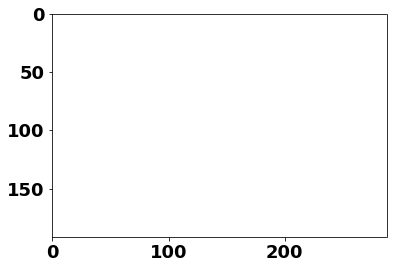

In [63]:
fig, ax_corr = plt.subplots(1, 1, figsize=(6, 6))
ax_corr.imshow(corr_results[0], cmap='gray')